In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_path = r"C:\Users\admin\Desktop\Userfull_Data.csv"
# writer = SummaryWriter("../logs")
df = pd.read_csv(data_path, encoding='utf-8')
ID = df['id'].value_counts().index
ID

Index([263,  77,   7,  95, 232,  23, 271, 130,  68, 227, 228, 164, 111, 251,
       155, 245, 229, 277, 193, 137],
      dtype='int64', name='id')

In [3]:
seq = 48  # 这个也算超参数之一
total_data = []
for i in ID:
    data = df[df['id'] == i].copy()
    data['time'] = pd.to_datetime(data['time'])
    data = data.sort_values(by='time')
    # 时间为行索引
    data.index = data['time']

    # 设置标签
    data['target'] = data['gl'].shift(-1)
    # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data.dropna()  
    # 修改数据类型
    data = data[['gl', 'target']].astype(np.float32)
    # 所有受试者中血糖数据个数最小 为16439
    data = data.gl.values
    print("id为{}的数据长度为data.shape: ".format(i),data.shape)
    total_data.append(data)

total_data = np.array(total_data)
train_data = total_data[:, :-seq]
test_data = total_data[:, -seq:]
print(train_data.shape)
print(test_data.shape)

id为263的数据长度为data.shape:  (2016,)
id为77的数据长度为data.shape:  (2016,)
id为7的数据长度为data.shape:  (2016,)
id为95的数据长度为data.shape:  (2016,)
id为232的数据长度为data.shape:  (2016,)
id为23的数据长度为data.shape:  (2016,)
id为271的数据长度为data.shape:  (2016,)
id为130的数据长度为data.shape:  (2016,)
id为68的数据长度为data.shape:  (2016,)
id为227的数据长度为data.shape:  (2016,)
id为228的数据长度为data.shape:  (2016,)
id为164的数据长度为data.shape:  (2016,)
id为111的数据长度为data.shape:  (2016,)
id为251的数据长度为data.shape:  (2016,)
id为155的数据长度为data.shape:  (2016,)
id为245的数据长度为data.shape:  (2016,)
id为229的数据长度为data.shape:  (2016,)
id为277的数据长度为data.shape:  (2016,)
id为193的数据长度为data.shape:  (2016,)
id为137的数据长度为data.shape:  (2016,)
(20, 1968)
(20, 48)


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.T)
train_data_normalized = train_data_normalized.T
print(train_data_normalized.shape)

(20, 1968)


In [5]:
L = train_data_normalized.shape[1]
all_feat = []
all_targets = []
for j in range(train_data_normalized.shape[0]):
    for i in range(L - seq):
        train_seq = train_data_normalized[j, i:i + seq]
        train_label = train_data_normalized[j, i + seq]
        all_feat.append(train_seq)
        all_targets.append(train_label)

all_feat = np.array(all_feat)
all_targets = np.array(all_targets)
all_feat = torch.tensor(all_feat).unsqueeze(-1)
all_targets = torch.tensor(all_targets)
print(all_targets.shape)

torch.Size([38400])


In [6]:
print(all_feat.shape)

torch.Size([38400, 48, 1])


In [7]:
train = TensorDataset(all_feat,all_targets)
train_loader = DataLoader(dataset=train,batch_size=128, shuffle=False)

In [8]:
import torch
from torch import nn
device = torch.device("cuda:0")

class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(myLSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])

        return out

if __name__ == "__main__":
    input_dim = 1  # 数据的特征数
    hidden_dim = 64  # 隐藏层的神经元个数
    num_layers = 2  # LSTM的层数
    output_dim = 1  # 预测值的特征数

    model = myLSTM(input_dim=input_dim, hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)
    model = model.to(device)
    input =torch.ones((2,500,1)).to(device)
    output = model(input)
    print(output.shape)

torch.Size([2, 1])


In [9]:
input_dim = 1  # 数据的特征数
hidden_dim = 32  # 隐藏层的神经元个数
num_layers = 2  # LSTM的层数
output_dim = 1  # 预测值的特征数

model = myLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
if torch.cuda.is_available():
    allen = model.cuda()

# 定义优化器和损失函数
loss_fn = torch.nn.MSELoss(reduction='mean')  # 使用均方误差作为损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)  # 使用Adam优化算法
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

In [10]:
# 设定数据遍历次数
num_epochs = 300
# 记录训练次数
total_train_step = 0
# 记录测试次数
total_test_step = 0

for t in range(num_epochs):
    print("----------第 {} 轮训练开始----------".format(t + 1))
    model.train()
    for data in train_loader:
        trains, targets = data
        if torch.cuda.is_available():
            trains = trains.cuda()
            targets = targets.cuda()
        y_train_pred = model(trains)
        y_train_pred = y_train_pred.squeeze(-1)
        loss = loss_fn(y_train_pred, targets)

        optimiser.zero_grad()  # 梯度清零

        # Backward pass
        loss.backward()  # 反向传播

        # Update parameters
        optimiser.step()  # 参数优化
        total_train_step += 1

        if total_train_step % 100 == 0 :  # 每训练100次，打印一次均方差
            print("训练次数： ", total_train_step, "MSE: ", loss.item())
        # 逢100记录一次Loss
#         writer.add_scalar("train_loss", loss.item(), total_train_step)
    torch.save(model, r"E:\pythonProject\RNN_study\CGM\pre_trained_model\allen_{}.pth".format(t))
    print("allen_{}.pth 模型已保存".format(t))
    

----------第 1 轮训练开始----------
训练次数：  100 MSE:  0.0021484517492353916
训练次数：  200 MSE:  0.017920825630426407
训练次数：  300 MSE:  0.0008748271502554417
allen_0.pth 模型已保存
----------第 2 轮训练开始----------
训练次数：  400 MSE:  0.0006856443942524493
训练次数：  500 MSE:  0.01458893995732069
训练次数：  600 MSE:  0.0005214374978095293
allen_1.pth 模型已保存
----------第 3 轮训练开始----------
训练次数：  700 MSE:  0.0006790883489884436
训练次数：  800 MSE:  0.014141682535409927
训练次数：  900 MSE:  0.0003942277398891747
allen_2.pth 模型已保存
----------第 4 轮训练开始----------
训练次数：  1000 MSE:  0.0007180224056355655
训练次数：  1100 MSE:  0.014020967297255993
训练次数：  1200 MSE:  0.00040285493014380336
allen_3.pth 模型已保存
----------第 5 轮训练开始----------
训练次数：  1300 MSE:  0.0007223753491416574
训练次数：  1400 MSE:  0.013877920806407928
训练次数：  1500 MSE:  0.002060442231595516
allen_4.pth 模型已保存
----------第 6 轮训练开始----------
训练次数：  1600 MSE:  0.0007083199452608824
训练次数：  1700 MSE:  0.013675815425813198
训练次数：  1800 MSE:  0.0014125870075076818
allen_5.pth 模型已保存
--------

训练次数：  14800 MSE:  0.0006777276284992695
训练次数：  14900 MSE:  0.012525977566838264
训练次数：  15000 MSE:  0.00034860774758271873
allen_49.pth 模型已保存
----------第 51 轮训练开始----------
训练次数：  15100 MSE:  0.0006769769825041294
训练次数：  15200 MSE:  0.012340698391199112
训练次数：  15300 MSE:  0.0003481440944597125
allen_50.pth 模型已保存
----------第 52 轮训练开始----------
训练次数：  15400 MSE:  0.0006765517173334956
训练次数：  15500 MSE:  0.012461739592254162
训练次数：  15600 MSE:  0.0003536997246555984
allen_51.pth 模型已保存
----------第 53 轮训练开始----------
训练次数：  15700 MSE:  0.0006675223121419549
训练次数：  15800 MSE:  0.012647848576307297
训练次数：  15900 MSE:  0.00037804729072377086
allen_52.pth 模型已保存
----------第 54 轮训练开始----------
训练次数：  16000 MSE:  0.0006533389678224921
训练次数：  16100 MSE:  0.012545573525130749
训练次数：  16200 MSE:  0.00038880459032952785
allen_53.pth 模型已保存
----------第 55 轮训练开始----------
训练次数：  16300 MSE:  0.00065019162138924
训练次数：  16400 MSE:  0.012384282425045967
训练次数：  16500 MSE:  0.00038803325151093304
allen_54.pth 模型已

训练次数：  29200 MSE:  0.010215839371085167
训练次数：  29300 MSE:  0.022139646112918854
训练次数：  29400 MSE:  0.016814442351460457
allen_97.pth 模型已保存
----------第 99 轮训练开始----------
训练次数：  29500 MSE:  0.010113770142197609
训练次数：  29600 MSE:  0.019407503306865692
训练次数：  29700 MSE:  0.0192212276160717
allen_98.pth 模型已保存
----------第 100 轮训练开始----------
训练次数：  29800 MSE:  0.008404109627008438
训练次数：  29900 MSE:  0.022386813536286354
训练次数：  30000 MSE:  0.018734224140644073
allen_99.pth 模型已保存
----------第 101 轮训练开始----------
训练次数：  30100 MSE:  0.008513420820236206
训练次数：  30200 MSE:  0.021478893235325813
训练次数：  30300 MSE:  0.016745910048484802
allen_100.pth 模型已保存
----------第 102 轮训练开始----------
训练次数：  30400 MSE:  0.008704664185643196
训练次数：  30500 MSE:  0.027723439037799835
训练次数：  30600 MSE:  0.015924593433737755
allen_101.pth 模型已保存
----------第 103 轮训练开始----------
训练次数：  30700 MSE:  0.009306111373007298
训练次数：  30800 MSE:  0.025588707998394966
训练次数：  30900 MSE:  0.017471879720687866
allen_102.pth 模型已保存
------

训练次数：  43700 MSE:  0.01380888745188713
训练次数：  43800 MSE:  0.0005042597185820341
allen_145.pth 模型已保存
----------第 147 轮训练开始----------
训练次数：  43900 MSE:  0.0007608961896039546
训练次数：  44000 MSE:  0.013231239281594753
训练次数：  44100 MSE:  0.000510836485773325
allen_146.pth 模型已保存
----------第 148 轮训练开始----------
训练次数：  44200 MSE:  0.0007107802666723728
训练次数：  44300 MSE:  0.012449932284653187
训练次数：  44400 MSE:  0.0004971636808477342
allen_147.pth 模型已保存
----------第 149 轮训练开始----------
训练次数：  44500 MSE:  0.0006837130058556795
训练次数：  44600 MSE:  0.011988156475126743
训练次数：  44700 MSE:  0.0005103737348690629
allen_148.pth 模型已保存
----------第 150 轮训练开始----------
训练次数：  44800 MSE:  0.0006660999497398734
训练次数：  44900 MSE:  0.011976530775427818
训练次数：  45000 MSE:  0.0005009047454223037
allen_149.pth 模型已保存
----------第 151 轮训练开始----------
训练次数：  45100 MSE:  0.0006544006755575538
训练次数：  45200 MSE:  0.012022431008517742
训练次数：  45300 MSE:  0.0005372935556806624
allen_150.pth 模型已保存
----------第 152 轮训练开始----------

训练次数：  58000 MSE:  0.0016408731462433934
训练次数：  58100 MSE:  0.02076198160648346
训练次数：  58200 MSE:  0.0038540861569344997
allen_193.pth 模型已保存
----------第 195 轮训练开始----------
训练次数：  58300 MSE:  0.0014119746629148722
训练次数：  58400 MSE:  0.020456494763493538
训练次数：  58500 MSE:  0.003288936335593462
allen_194.pth 模型已保存
----------第 196 轮训练开始----------
训练次数：  58600 MSE:  0.001230333000421524
训练次数：  58700 MSE:  0.02023380994796753
训练次数：  58800 MSE:  0.002935310360044241
allen_195.pth 模型已保存
----------第 197 轮训练开始----------
训练次数：  58900 MSE:  0.0011216943385079503
训练次数：  59000 MSE:  0.02021370641887188
训练次数：  59100 MSE:  0.002575705759227276
allen_196.pth 模型已保存
----------第 198 轮训练开始----------
训练次数：  59200 MSE:  0.0011743975337594748
训练次数：  59300 MSE:  0.02056141011416912
训练次数：  59400 MSE:  0.0021399883553385735
allen_197.pth 模型已保存
----------第 199 轮训练开始----------
训练次数：  59500 MSE:  0.0010968323331326246
训练次数：  59600 MSE:  0.02076973207294941
训练次数：  59700 MSE:  0.0017384702805429697
allen_198.pth 模型已

训练次数：  72300 MSE:  0.00037831446388736367
allen_240.pth 模型已保存
----------第 242 轮训练开始----------
训练次数：  72400 MSE:  0.0006385608576238155
训练次数：  72500 MSE:  0.01342652179300785
训练次数：  72600 MSE:  0.00038492790190503
allen_241.pth 模型已保存
----------第 243 轮训练开始----------
训练次数：  72700 MSE:  0.0006456474075093865
训练次数：  72800 MSE:  0.013398037292063236
训练次数：  72900 MSE:  0.0003994123253505677
allen_242.pth 模型已保存
----------第 244 轮训练开始----------
训练次数：  73000 MSE:  0.0006449738284572959
训练次数：  73100 MSE:  0.013285748660564423
训练次数：  73200 MSE:  0.00041559519013389945
allen_243.pth 模型已保存
----------第 245 轮训练开始----------
训练次数：  73300 MSE:  0.0006451871595345438
训练次数：  73400 MSE:  0.013172087259590626
训练次数：  73500 MSE:  0.00044969184091314673
allen_244.pth 模型已保存
----------第 246 轮训练开始----------
训练次数：  73600 MSE:  0.0006477862480096519
训练次数：  73700 MSE:  0.012892797589302063
训练次数：  73800 MSE:  0.0004931609728373587
allen_245.pth 模型已保存
----------第 247 轮训练开始----------
训练次数：  73900 MSE:  0.0006411758949980

训练次数：  86500 MSE:  0.0027202561032027006
训练次数：  86600 MSE:  0.026476649567484856
训练次数：  86700 MSE:  0.0014415145851671696
allen_288.pth 模型已保存
----------第 290 轮训练开始----------
训练次数：  86800 MSE:  0.001643302384763956
训练次数：  86900 MSE:  0.0285947285592556
训练次数：  87000 MSE:  0.0014897624496370554
allen_289.pth 模型已保存
----------第 291 轮训练开始----------
训练次数：  87100 MSE:  0.0017287186346948147
训练次数：  87200 MSE:  0.060926854610443115
训练次数：  87300 MSE:  0.011628769338130951
allen_290.pth 模型已保存
----------第 292 轮训练开始----------
训练次数：  87400 MSE:  0.0027772311586886644
训练次数：  87500 MSE:  0.01466178148984909
训练次数：  87600 MSE:  0.0012826225720345974
allen_291.pth 模型已保存
----------第 293 轮训练开始----------
训练次数：  87700 MSE:  0.0031163166277110577
训练次数：  87800 MSE:  0.014779378660023212
训练次数：  87900 MSE:  0.0007921188371255994
allen_292.pth 模型已保存
----------第 294 轮训练开始----------
训练次数：  88000 MSE:  0.0011057790834456682
训练次数：  88100 MSE:  0.014543783850967884
训练次数：  88200 MSE:  0.0006001145811751485
allen_293.pth

In [11]:
model = torch.load(r"E:\pythonProject\RNN_study\CGM\pre_trained_model\allen_299.pth")
print(model)
fut_pred = 48
test_inputs = train_data_normalized[:,-48:]

model.eval()
test_inputs = torch.FloatTensor(test_inputs).cuda()
print(test_inputs.shape)

for i in range(fut_pred): 
    with torch.no_grad():
        seq = test_inputs[:,-48:].unsqueeze(-1)

        output = model(seq)

        test_inputs = torch.cat((test_inputs,output), dim=1)


test_inputs = test_inputs[:,-48:].cpu()
print(test_inputs[:5])

# 对于逆缩放方法的输入数据应该满足模型所记住的列数
test_inputs = test_inputs.T
actual_predictions = scaler.inverse_transform(np.array(test_inputs))
actual_predictions = actual_predictions.T
print("actual_predictions.shape:", actual_predictions.shape)

myLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
torch.Size([20, 48])
tensor([[ 0.0116,  0.0214,  0.0382,  0.0596,  0.0859,  0.1144,  0.1451,  0.1758,
          0.2052,  0.2318,  0.2559,  0.2779,  0.2983,  0.3170,  0.3347,  0.3527,
          0.3710,  0.3895,  0.4083,  0.4274,  0.4469,  0.4665,  0.4878,  0.5103,
          0.5348,  0.5615,  0.5907,  0.6224,  0.6574,  0.6959,  0.7375,  0.7810,
          0.8225,  0.8620,  0.8933,  0.9168,  0.9306,  0.9383,  0.9417,  0.9436,
          0.9457,  0.9471,  0.9480,  0.9486,  0.9486,  0.9480,  0.9470,  0.9457],
        [-0.7941, -0.7705, -0.7347, -0.6878, -0.6375, -0.5916, -0.5579, -0.5367,
         -0.5228, -0.5103, -0.4944, -0.4737, -0.4503, -0.4244, -0.3955, -0.3633,
         -0.3265, -0.2845, -0.2374, -0.1848, -0.1250, -0.0558,  0.0271,  0.1248,
          0.2317,  0.3326,  0.4162,  0.4827,  0.5345,  0.5744,  0.6070,  0.6361,
          0.6644,  0.6925,  0.7201,  0.7480,  

In [12]:
actual_predictions[9]

array([302.19904, 305.46115, 309.3901 , 312.97562, 316.9954 , 320.9036 ,
       325.09436, 328.82037, 332.6212 , 336.06274, 339.29715, 342.2637 ,
       344.40857, 345.66855, 346.42767, 346.80228, 346.88428, 346.75607,
       346.5898 , 346.48526, 346.91718, 347.99997, 348.5894 , 347.41006,
       346.065  , 345.6491 , 345.10297, 344.38724, 343.7893 , 342.9728 ,
       342.30615, 341.66885, 341.0238 , 340.4242 , 339.87924, 339.49112,
       339.4128 , 339.81302, 340.70923, 342.35016, 343.4828 , 344.45148,
       345.0926 , 345.538  , 345.66806, 345.68695, 345.671  , 345.91803],
      dtype=float32)

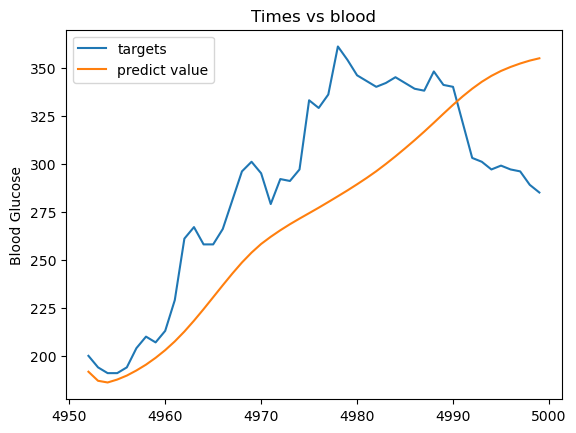

In [21]:
from matplotlib import pyplot as plt
x = np.arange(4952,5000)
# plt.figure(figsize=(20,8),dpi=80)
plt.title('Times vs blood')
plt.ylabel('Blood Glucose')
plt.plot(x,test_data[8], label="targets")
plt.plot(x,actual_predictions[8],label="predict value")
plt.legend()
plt.show()